### Question 1: What are voting classifiers in ensemble learning?

Voting classifiers have two types, which are hard and soft voting classifiers. It is to combine the predictions of multiple individual classifiers to make a final decision, show a more accurate result.

(Hard) voting classifiers: each individual classifier in the ensemble predicts the class label, and the class label that receives the majority of the votes is chosen as the final prediction. This is similar to a majority vote we did in python lab.

(soft) voting classifiers: each individual classifier assigns a probability or confidence score to each class for a given input. The final prediction is made by taking a weighted average of these probability scores from all the classifiers. 

### Question 2: Explain the role of the regularization parameter C in a Support Vector machine (SVM) model. How does varying C affect the model's bias and variance trade-off?

The role of C is a non-negative tuning parameter, it can control the balance between maximizing the margin (which reduces bias) and minimizing the classification error (which reduces variance). It is part of the regularization term in the SVM's objective function and influences the positioning of the decision boundary and the choice of support vectors.

small C: Smaller C may results in a larger-margin decision boundary and lead to fewer support vectors. These support vectors are the data points closest to the decision boundary, and they have a more significant influence on the model.
The model tends to have higher bias (cause underfitting) but lower variance. It generalizes better to unseen data but might not capture the training data intricacies. Therefore, small C more robust to outliers and noise, but potentially less accurate on the training data.

large C: larger C results in a smaller-margin decision boundary and may include more support vectors. The model becomes more sensitive to individual data points and fits the training data more closely. Also, the model tends to have lower bias (overfitting) but higher variance. So, it potentially fitting the training data more closely but being more sensitive to outliers and having a higher risk of overfitting.

### Question 3: Follow the 7-steps to model building for your selected ticker

In [254]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(rc={'figure.figsize': (20,8)})

#Data preprocessing
from sklearn.model_selection import (train_test_split, GridSearchCV,TimeSeriesSplit,cross_val_score)
from sklearn.preprocessing import (MinMaxScaler, StandardScaler)
from sklearn.pipeline import Pipeline

#Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#metrics
from sklearn.metrics import (precision_recall_curve, roc_curve,RocCurveDisplay,ConfusionMatrixDisplay)
from sklearn.metrics import (accuracy_score,f1_score,recall_score,precision_score,roc_auc_score,auc)
from sklearn.metrics import (classification_report,confusion_matrix)

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [255]:
#Load Data
df = pd.read_csv(r"C:\Users\Taoye\OneDrive\桌面\CQF exam 3\BTC-CAD (1).csv",index_col=0,parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-10-14,10985.246094,11103.149414,10960.775391,11076.603516,11076.603516,20039664973
2019-10-15,11074.978516,11123.372070,10798.039063,10835.034180,10835.034180,20098265692
2019-10-16,10834.117188,10850.752930,10535.806641,10625.793945,10625.793945,21220681260
2019-10-17,10626.170898,10684.743164,10569.125000,10645.508789,10645.508789,18801997567
2019-10-18,10641.596680,10690.432617,10379.113281,10466.030273,10466.030273,20545063040


In [256]:
df.shape

(1462, 6)

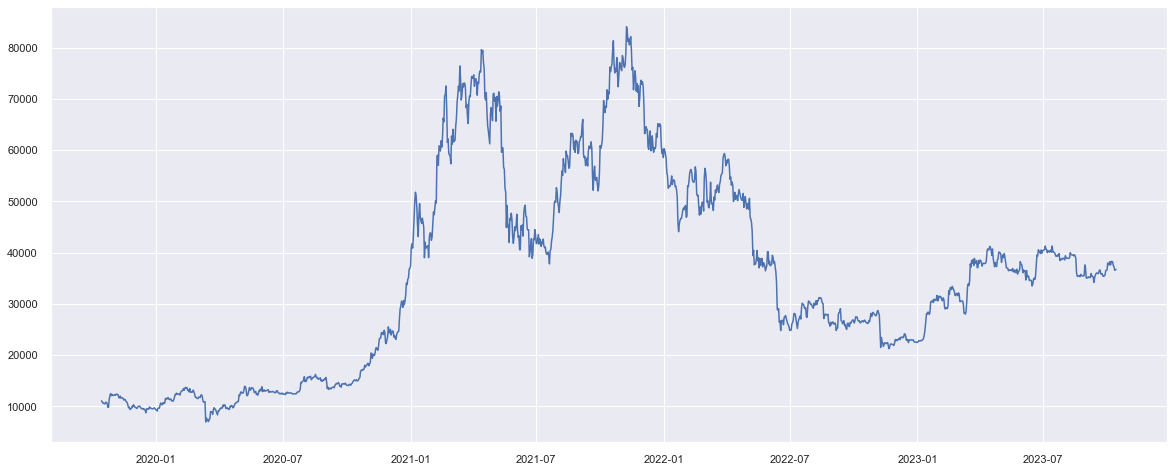

In [257]:
#Visualize data
plt.plot(df['Adj Close'])

In [258]:
#EDA of Original dataset
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1.462000e+03
mean,35168.877774,35948.767751,34315.180088,35181.514872,35181.514872,4.182699e+10
std,19278.649411,19779.360792,18685.711271,19262.474938,19262.474938,2.364726e+10
min,6996.441895,7438.541992,5720.531250,6930.849121,6930.849121,7.245330e+09
25%,15658.673828,15873.335205,15474.832032,15700.940918,15700.940918,2.666449e+10
50%,34773.150391,35367.914062,34255.244140,34889.406250,34889.406250,3.777779e+10
75%,48960.145508,50394.922852,47545.381836,48991.664062,48991.664062,5.111976e+10
max,84050.781250,85357.960938,82605.906250,84072.054688,84072.054688,4.470696e+11


In [259]:
#Cleaning & Imputation
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [260]:
#Feature Specification
#Features
df['O-C'] = df.Open - df.Close
df['H-L'] = df.High - df.Low
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
for i in range(1,6):
    df[f'Return_{i}'] = df['Close'].shift(i)

df['Momentum_10'] = df['Close'] - df['Close'].shift(10)

X = df[['O-C','H-L','SMA_20','EMA_10','Return_1', 'Return_2', 'Return_3', 'Return_4', 'Return_5', 'Momentum_10']]
X = X.fillna(0)
X

,O-C,H-L,SMA_20,EMA_10,Return_1,Return_2,Return_3,Return_4,Return_5,Momentum_10
Date,,,,,,,,,,
2019-10-14,-91.357422,142.374023,0.000000,11076.603516,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-10-15,239.944336,325.333007,0.000000,11032.681819,11076.603516,0.000000,0.000000,0.000000,0.000000,0.000000
2019-10-16,208.323243,314.946289,0.000000,10958.702205,10835.034180,11076.603516,0.000000,0.000000,0.000000,0.000000
2019-10-17,-19.337891,115.618164,0.000000,10901.757948,10625.793945,10835.034180,11076.603516,0.000000,0.000000,0.000000
2019-10-18,175.566407,311.319336,0.000000,10822.534734,10645.508789,10625.793945,10835.034180,11076.603516,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2023-10-10,706.726562,992.230469,36836.413477,37610.188680,38168.550781,38271.160156,38240.726563,37579.539063,38209.156250,900.062500
2023-10-11,259.617188,543.515625,36868.392774,37537.220426,37460.980469,38168.550781,38271.160156,38240.726563,37579.539063,558.117187
2023-10-12,673.441406,1142.300781,36904.849609,37355.336598,37208.863281,37460.980469,38168.550781,38271.160156,38240.726563,-1448.144531


In [261]:
#Target- [0,1]
y = np.where(df['Adj Close'].shift(-1)>0.995*df['Adj Close'],1,0)
y

array([0, 0, 1, ..., 1, 1, 0])

In [262]:
#value counts for class 1 and 0
pd.Series(y).value_counts()

1    906
0    556
dtype: int64

In [263]:
#Split Data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=False)
print(f"Train and Test Size {len(X_train)},{len(X_test)}")

Train and Test Size 1169,293


### Base Model


In [264]:
#Fit model
#Scale and fit the model
model = Pipeline([
    ("scaler", MinMaxScaler()),
    ("classifier", RandomForestClassifier(n_estimators= 10, max_depth= 20))
])
model.fit(X_train,y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=20, n_estimators=10))])

In [265]:
#predicting the test dataset
y_pred = model.predict(X_test)

#Predict probabilities
y_proba = model.predict_proba(X_test)

In [266]:
#verify the class labels
model.classes_

array([0, 1])

In [267]:
#predict probability
y_proba[-20:]

array([[0.4       , 0.6       ],
       [0.34594595, 0.65405405],
       [0.54594595, 0.45405405],
       [0.21261261, 0.78738739],
       [0.04594595, 0.95405405],
       [0.24594595, 0.75405405],
       [0.54594595, 0.45405405],
       [0.1       , 0.9       ],
       [0.2       , 0.8       ],
       [0.4375    , 0.5625    ],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.2       , 0.8       ],
       [0.4375    , 0.5625    ],
       [0.4       , 0.6       ],
       [0.6       , 0.4       ],
       [0.2       , 0.8       ],
       [0.48333333, 0.51666667],
       [0.64594595, 0.35405405],
       [0.44594595, 0.55405405]])

In [268]:
#predict class lables
y_pred[-20:]

array([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1])

In [269]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test,y_pred)

print(f"Train Accuracy: {acc_train:0.4}, Test Accuracy:{acc_test:0.4}")


Train Accuracy: 0.9718, Test Accuracy:0.5495


### Prediction Quality and Visualization


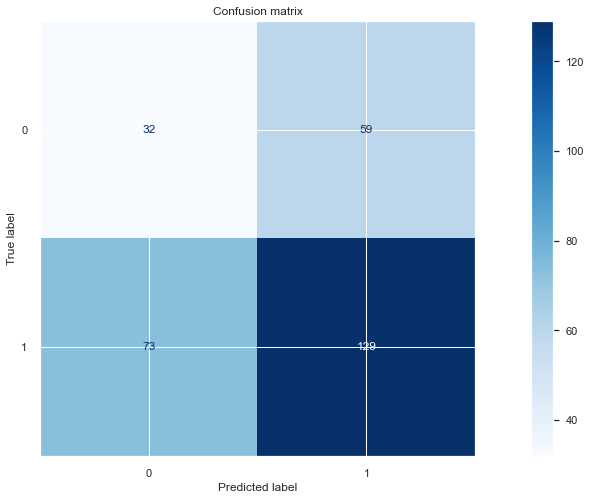

In [270]:
#Confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.show()

In [271]:
#Classification Report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.30      0.35      0.33        91
           1       0.69      0.64      0.66       202

    accuracy                           0.55       293
   macro avg       0.50      0.50      0.49       293
weighted avg       0.57      0.55      0.56       293



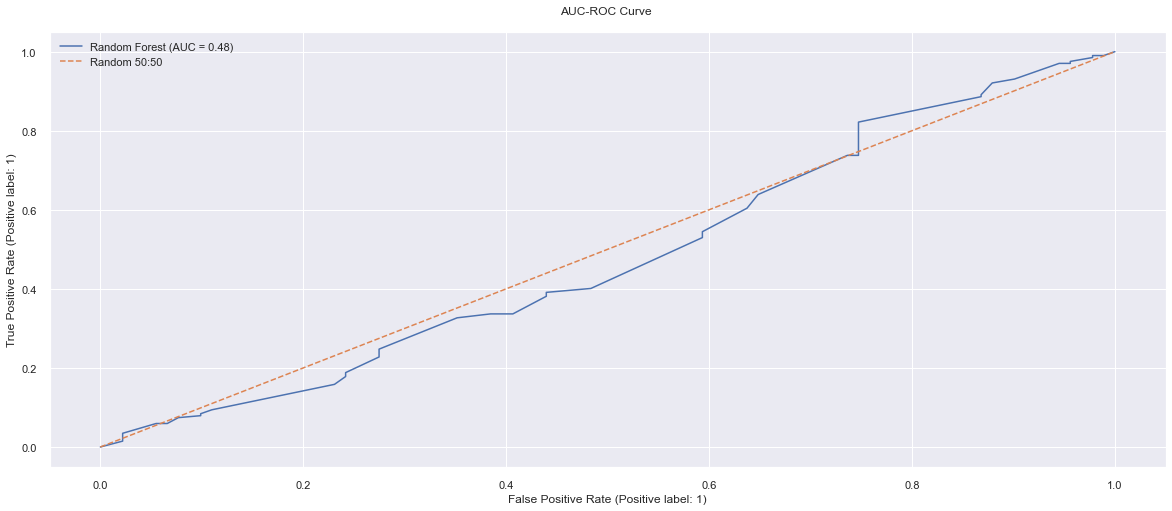

In [272]:
#ROC
#Display ROCCurve
disp = RocCurveDisplay.from_estimator(model,X_test,y_test,name='Random Forest')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--",label='Random 50:50')
plt.legend()
plt.show()

### Hyper-parameter Tuning

In [273]:
#Cross-validation
tscv = TimeSeriesSplit(n_splits=8, gap=1)
for train, test in tscv.split(X):
    print(train, test)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164] [166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 246 

In [274]:
tscv = TimeSeriesSplit(n_splits=5, gap=1)

In [275]:
# GridSearch
model.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('classifier', RandomForestClassifier(max_depth=20, n_estimators=10))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'classifier': RandomForestClassifier(max_depth=20, n_estimators=10),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'classifier__bootstrap': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight': None,
 'classifier__criterion': 'gini',
 'classifier__max_depth': 20,
 'classifier__max_features': 'auto',
 'classifier__max_leaf_nodes': None,
 'classifier__max_samples': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__min_weight_fraction_leaf': 0.0,
 'classifier__n_estimators': 10,
 'classifier__n_jobs': None,
 'classifier__oob_score': False,
 'classifier__random_state': None,
 'classifier__verbose': 0,
 'classifier__warm_start': False}

In [276]:
#perform GridSearch and fit
param_grid = {"classifier__n_estimators": np.arange(1,51,1),
             'classifier__max_depth': [10,20,30,40,50],
             'classifier__min_samples_split':[2,5,10],
             'classifier__min_samples_leaf':[1,2,4]}

gs = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1,cv=tscv,verbose=1)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 2250 candidates, totalling 11250 fits


GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('classifier',
                                        RandomForestClassifier(max_depth=20,
                                                               n_estimators=10))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, 30, 40, 50],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
             scoring='roc_auc', verbose=1)

In [278]:
#Best Params & Scores
print(f"Optimal Estimators:{gs.best_params_['classifier__n_estimators']}, Best Score:{round(gs.best_score_,4)}")

Optimal Estimators:17, Best Score:0.5647


### Tuned Model

In [279]:
#Instantiate KNN model with search param
clf = RandomForestClassifier(n_estimators=gs.best_params_['classifier__n_estimators'], max_depth = 10, min_samples_split=3)

#Fit the model
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=3, n_estimators=17)

In [280]:
#Predictingb the test data
y_pred = clf.predict(X_test)

#Predict probabilities
y_proba = clf.predict_proba(X_test)[:,1]

#Measure Accuracy
acc_train = accuracy_score(y_train, clf.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

print(f"\n Training Accuracy \t: {acc_train:0.4} \n Test Accuracy \t\t:{acc_test:0.4}")


 Training Accuracy 	: 0.8922 
 Test Accuracy 		:0.6792


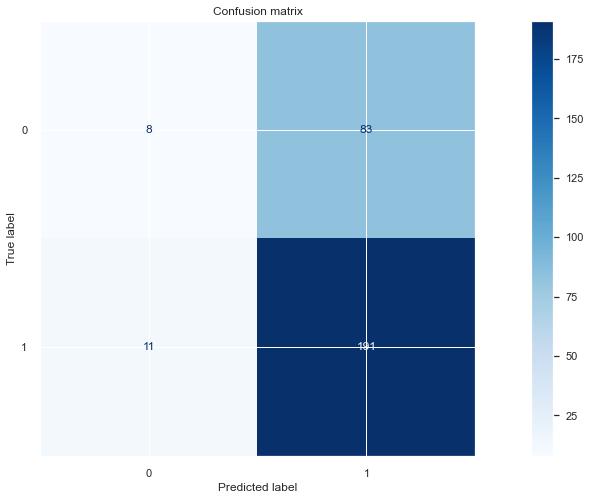

In [281]:
#Display confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf,X_test,y_test,display_labels=model.classes_, cmap = plt.cm.Blues)

plt.title('Confusion matrix')
plt.show()

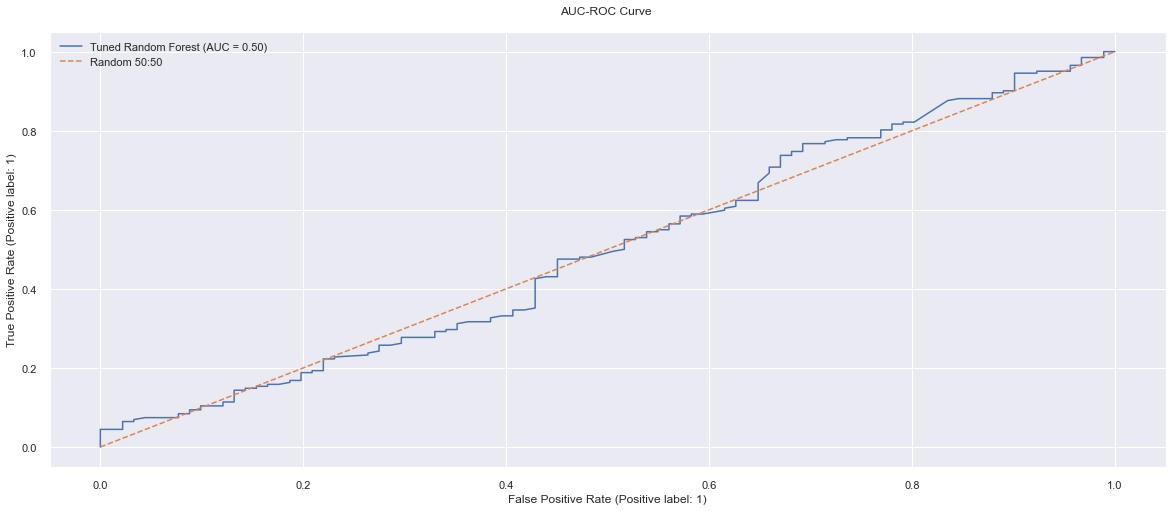

In [282]:
#Display ROCCurve
disp = RocCurveDisplay.from_estimator(clf,X_test,y_test,name = 'Tuned Random Forest')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

In [283]:
#Classification Rport
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.09      0.15        91
           1       0.70      0.95      0.80       202

    accuracy                           0.68       293
   macro avg       0.56      0.52      0.47       293
weighted avg       0.61      0.68      0.60       293



### Trading Strategy

In [284]:
#Submine into a new dataframe
df1 = df.copy()
df1['Signal'] = clf.predict(X)


In [285]:
#Daily Returns - Benchmark return
df1['Returns'] = np.log(df1['Adj Close']).diff().fillna(0)

df1['Strategy'] = df1['Returns'] * df1['Signal'].shift(1).fillna(0)

df1.index = df1.index.tz_localize('utc')


In [291]:
print(df1.tail(10), df1.head(20))

                                   Open          High           Low  \
Date                                                                  
2023-10-05 00:00:00+00:00  37604.851563  38246.070313  37343.531250   
2023-10-06 00:00:00+00:00  38208.128906  38551.164063  37554.289063   
2023-10-07 00:00:00+00:00  37574.343750  38659.359375  37324.632813   
2023-10-08 00:00:00+00:00  38240.980469  38352.238281  38136.492188   
2023-10-09 00:00:00+00:00  38275.046875  38453.605469  37958.937500   
2023-10-10 00:00:00+00:00  38167.707031  38194.292969  37202.062500   
2023-10-11 00:00:00+00:00  37468.480469  37644.773438  37101.257813   
2023-10-12 00:00:00+00:00  37210.300781  37322.128906  36179.828125   
2023-10-13 00:00:00+00:00  36536.820313  36601.042969  36339.589844   
2023-10-14 00:00:00+00:00  36729.468750  36861.839844  36698.671875   

                                  Close     Adj Close       Volume  \
Date                                                                 
2023-10

In [287]:
#Return analysis
import pyfolio as pf

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.98,2022-04-28,2022-06-13,2022-07-14,56
1,20.30,2023-04-15,2023-06-15,NaT,NaN
2,16.60,2023-02-20,2023-03-11,2023-03-15,18
3,13.62,2022-08-13,2022-08-19,2022-09-09,20
4,11.62,2022-01-15,2022-01-21,2022-02-04,15


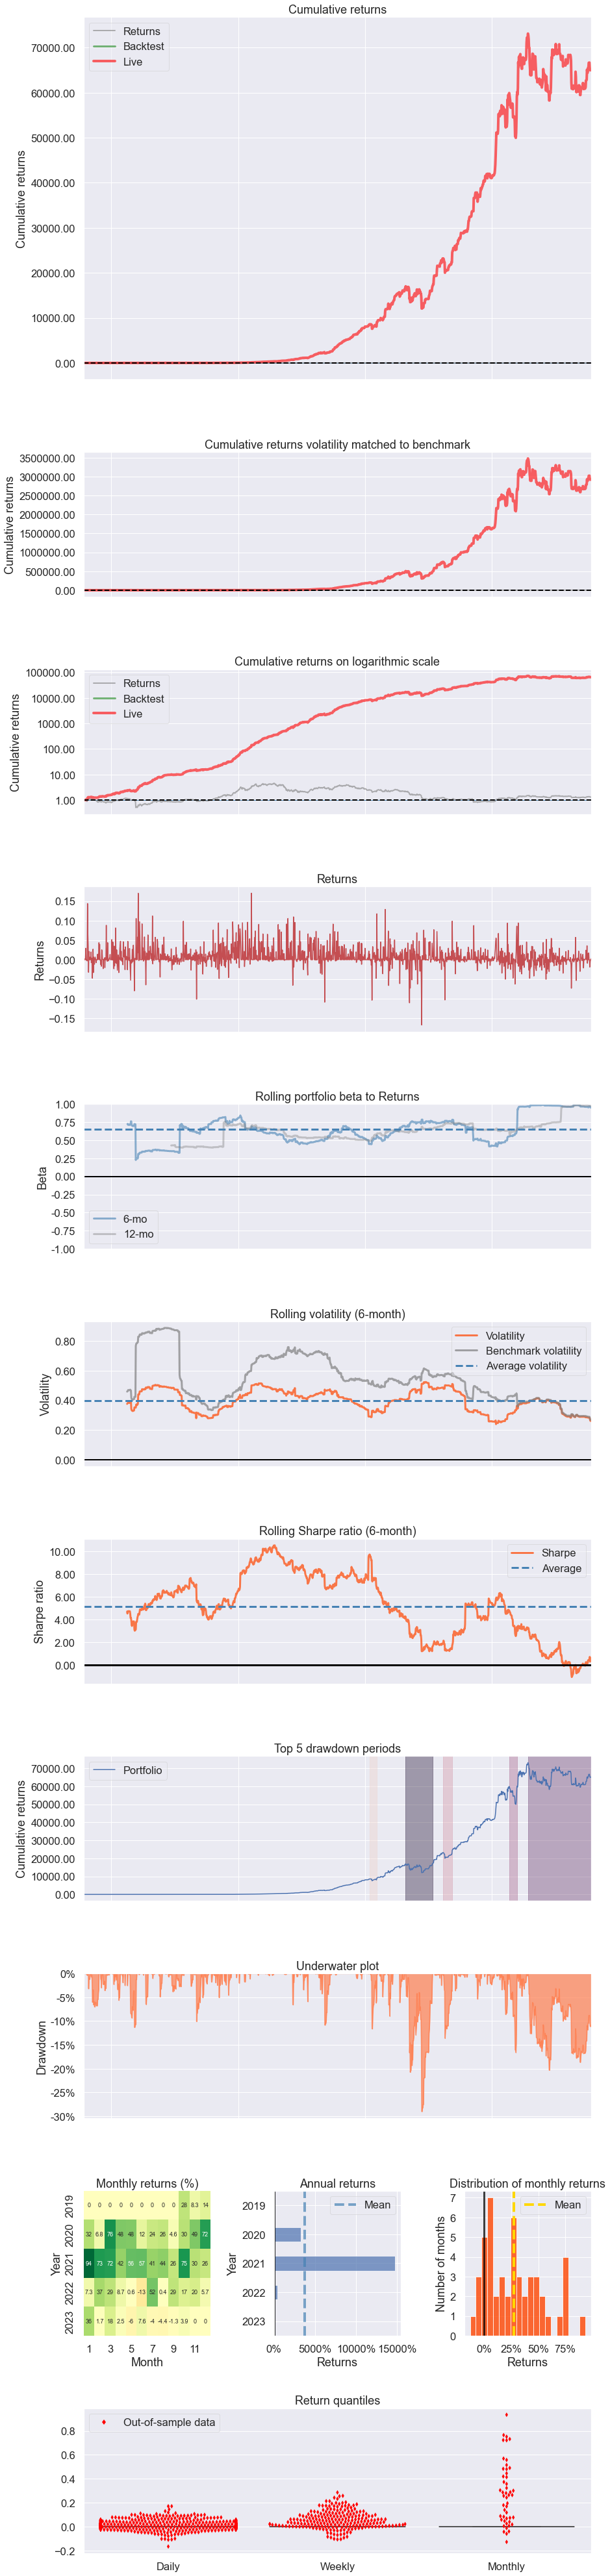

In [288]:
pf.create_returns_tear_sheet(df1['Strategy'],live_start_date='2019-10-15', benchmark_rets=df1['Returns'])

In [289]:
pip install boruta

Note: you may need to restart the kernel to use updated packages.


In [290]:
#Voting Classifiers
rf_classifier = RandomForestClassifier(random_state=42)
from sklearn.tree import DecisionTreeClassifier
other_classifier = DecisionTreeClassifier(random_state=42)

# Create a Voting Classifier with the individual classifiers
from sklearn.ensemble import VotingClassifier
voting_classifier = VotingClassifier(estimators=[('rf', rf_classifier), ('other', other_classifier)], voting='soft')
voting_classifier.fit(X_train, y_train)

# Evaluate the Voting Classifier
y_pred_voting = voting_classifier.predict(X_test)

# Calculate performance metrics for the Voting Classifier
roc_auc_voting = roc_auc_score(y_test, y_pred_voting)
confusion_voting = confusion_matrix(y_test, y_pred_voting)
classification_rep_voting = classification_report(y_test, y_pred_voting)

# Print the results for the Voting Classifier
print(f"Area Under ROC Curve (Voting): {roc_auc_voting}")
print("Confusion Matrix (Voting):")
print(confusion_voting)
print("Classification Report (Voting):")
print(classification_rep_voting)

# Perform Boruta Feature Selection
from boruta import BorutaPy

# Create a Boruta feature selector
boruta_selector = BorutaPy(rf_classifier, n_estimators='auto', verbose=2, random_state=42)

# Fit the Boruta selector to the training data
boruta_selector.fit(X_train.values, y_train)

# Transform the data to keep selected features
X_train_selected = boruta_selector.transform(X_train.values)
X_test_selected = boruta_selector.transform(X_test.values)

Area Under ROC Curve (Voting): 0.5067185289957568
Confusion Matrix (Voting):
[[ 26  65]
 [ 55 147]]
Classification Report (Voting):
              precision    recall  f1-score   support

           0       0.32      0.29      0.30        91
           1       0.69      0.73      0.71       202

    accuracy                           0.59       293
   macro avg       0.51      0.51      0.51       293
weighted avg       0.58      0.59      0.58       293

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	9
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	